In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [2]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))
df.head()


Saving Route24304Train (1).csv to Route24304Train (1).csv


,Route,Date,Vehicle,Service,Start,End,Duration,Stop1,Stop1to2,Stop2,...,Stop16,Stop16to17,Stop17,Stop17to18,Stop18,Stop18to19,Stop19,Stop19to20,Stop20,Stop20to21
0,24304,6/1/2016,981383,99,6:30:10,7:16:14,0:46:04,0,0,30,...,50,147,35,133,46,55,49,104,34,127
1,24304,6/1/2016,981383,99,8:08:36,9:04:22,0:55:46,36,121,41,...,51,85,55,174,38,58,41,89,49,126
2,24304,6/1/2016,981383,99,11:08:30,12:23:35,1:15:05,73,333,22,...,47,136,35,82,80,84,27,152,22,319
3,24304,6/1/2016,981383,99,18:00:30,19:11:30,1:11:00,273,120,49,...,27,79,43,145,41,0,0,0,0,0
4,24304,6/1/2016,981383,99,20:26:30,21:19:45,0:53:15,110,193,24,...,40,159,40,77,38,285,22,118,18,155


# Data Type Conversion

In [3]:
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df["Start"] = pd.to_datetime(df["Start"], format="%H:%M:%S").dt.time
df["End"] = pd.to_datetime(df["End"], format="%H:%M:%S").dt.time
df["Duration"] = pd.to_timedelta(df["Duration"]).dt.total_seconds()
df.head()


,Route,Date,Vehicle,Service,Start,End,Duration,Stop1,Stop1to2,Stop2,...,Stop16,Stop16to17,Stop17,Stop17to18,Stop18,Stop18to19,Stop19,Stop19to20,Stop20,Stop20to21
0,24304,2016-06-01,981383,99,06:30:10,07:16:14,2764.0,0,0,30,...,50,147,35,133,46,55,49,104,34,127
1,24304,2016-06-01,981383,99,08:08:36,09:04:22,3346.0,36,121,41,...,51,85,55,174,38,58,41,89,49,126
2,24304,2016-06-01,981383,99,11:08:30,12:23:35,4505.0,73,333,22,...,47,136,35,82,80,84,27,152,22,319
3,24304,2016-06-01,981383,99,18:00:30,19:11:30,4260.0,273,120,49,...,27,79,43,145,41,0,0,0,0,0
4,24304,2016-06-01,981383,99,20:26:30,21:19:45,3195.0,110,193,24,...,40,159,40,77,38,285,22,118,18,155


# Checking for missed values and anomalies

In [4]:
missing_values = df.isnull().sum()
print("missing values in dataset:\n", missing_values)

df.describe()


missing values in dataset:
 Route         0
Date          0
Vehicle       0
Service       0
Start         0
End           0
Duration      0
Stop1         0
Stop1to2      0
Stop2         0
Stop2to3      0
Stop3         0
Stop3to4      0
Stop4         0
Stop4to5      0
Stop5         0
Stop5to6      0
Stop6         0
Stop6to7      0
Stop7         0
Stop7to8      0
Stop8         0
Stop8to9      0
Stop9         0
Stop9to10     0
Stop10        0
Stop10to11    0
Stop11        0
Stop11to12    0
Stop12        0
Stop12to13    0
Stop13        0
Stop13to14    0
Stop14        0
Stop14to15    0
Stop15        0
Stop15to16    0
Stop16        0
Stop16to17    0
Stop17        0
Stop17to18    0
Stop18        0
Stop18to19    0
Stop19        0
Stop19to20    0
Stop20        0
Stop20to21    0
dtype: int64


,Route,Date,Vehicle,Service,Duration,Stop1,Stop1to2,Stop2,Stop2to3,Stop3,...,Stop16,Stop16to17,Stop17,Stop17to18,Stop18,Stop18to19,Stop19,Stop19to20,Stop20,Stop20to21
count,9567.0,9567,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,...,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000
mean,24304.0,2016-07-08 18:54:36.011288832,981394.307097,98.893697,3472.044424,64.391450,161.441413,52.874569,116.329466,40.456883,...,44.972823,110.676283,37.418522,153.128985,47.569876,206.998641,25.989129,76.085189,25.268945,123.567472
min,24304.0,2016-06-01 00:00:00,981322.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24304.0,2016-06-20 00:00:00,981373.000000,99.000000,2961.500000,27.000000,112.000000,31.000000,81.000000,31.000000,...,36.000000,84.000000,32.000000,127.500000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24304.0,2016-07-09 00:00:00,981393.000000,99.000000,3414.000000,50.000000,147.000000,39.000000,107.000000,39.000000,...,44.000000,111.000000,37.000000,162.000000,37.000000,115.000000,29.000000,84.000000,25.000000,124.000000
75%,24304.0,2016-07-28 00:00:00,981423.000000,99.000000,3856.500000,82.000000,183.000000,57.000000,145.000000,48.000000,...,52.000000,135.000000,43.000000,182.000000,46.000000,365.000000,40.000000,123.000000,38.000000,173.000000
max,24304.0,2016-08-15 00:00:00,981796.000000,99.000000,30132.000000,1519.000000,4878.000000,1035.000000,3916.000000,542.000000,...,268.000000,821.000000,192.000000,805.000000,898.000000,1710.000000,343.000000,529.000000,363.000000,1581.000000
std,0.0,NaN,42.997240,0.632826,1082.162679,59.713354,126.323511,39.885755,68.474865,15.987143,...,15.781718,38.297659,12.055287,58.472429,47.546077,229.622351,25.880636,65.655862,23.965533,125.921958


# Creating new features

In [5]:
df["Weekday"] = df["Date"].dt.weekday  # 0 - monday, 6 - sunday
df["Start_Hour"] = pd.to_datetime(df["Start"], format="%H:%M:%S").dt.hour

df.head()

,Route,Date,Vehicle,Service,Start,End,Duration,Stop1,Stop1to2,Stop2,...,Stop17,Stop17to18,Stop18,Stop18to19,Stop19,Stop19to20,Stop20,Stop20to21,Weekday,Start_Hour
0,24304,2016-06-01,981383,99,06:30:10,07:16:14,2764.0,0,0,30,...,35,133,46,55,49,104,34,127,2,6
1,24304,2016-06-01,981383,99,08:08:36,09:04:22,3346.0,36,121,41,...,55,174,38,58,41,89,49,126,2,8
2,24304,2016-06-01,981383,99,11:08:30,12:23:35,4505.0,73,333,22,...,35,82,80,84,27,152,22,319,2,11
3,24304,2016-06-01,981383,99,18:00:30,19:11:30,4260.0,273,120,49,...,43,145,41,0,0,0,0,0,2,18
4,24304,2016-06-01,981383,99,20:26:30,21:19:45,3195.0,110,193,24,...,40,77,38,285,22,118,18,155,2,20


I created new feautures for improving quality of model. Weekday – The travel time may depend on the day of the week (for example, there are more traffic jams on Monday than on Sunday).
Start_Hour (Start time of the trip) – Morning and evening rush hours may affect the duration of the trip

# Drop some columns

In [6]:
df = df[df["Duration"] > 0]


In [7]:
df.drop(columns=["Route", "Vehicle", "Service", "Start", "End", "Date"], inplace=True)

In [8]:
df.fillna(df.median(), inplace=True)

df.head()

,Duration,Stop1,Stop1to2,Stop2,Stop2to3,Stop3,Stop3to4,Stop4,Stop4to5,Stop5,...,Stop17,Stop17to18,Stop18,Stop18to19,Stop19,Stop19to20,Stop20,Stop20to21,Weekday,Start_Hour
0,2764.0,0,0,30,80,43,54,36,41,45,...,35,133,46,55,49,104,34,127,2,6
1,3346.0,36,121,41,165,54,109,67,111,50,...,55,174,38,58,41,89,49,126,2,8
2,4505.0,73,333,22,171,53,99,60,43,40,...,35,82,80,84,27,152,22,319,2,11
3,4260.0,273,120,49,118,52,54,42,56,48,...,43,145,41,0,0,0,0,0,2,18
4,3195.0,110,193,24,69,67,99,25,66,36,...,40,77,38,285,22,118,18,155,2,20


# Normalization

In [9]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

df_scaled = pd.DataFrame(scaled_data, columns=df.columns)
df_scaled.head()


,Duration,Stop1,Stop1to2,Stop2,Stop2to3,Stop3,Stop3to4,Stop4,Stop4to5,Stop5,...,Stop17,Stop17to18,Stop18,Stop18to19,Stop19,Stop19to20,Stop20,Stop20to21,Weekday,Start_Hour
0,0.091669,0.000000,0.000000,0.028986,0.020429,0.079336,0.030033,0.143426,0.037893,0.031802,...,0.182292,0.165217,0.051225,0.032164,0.142857,0.196597,0.093664,0.080329,0.333333,0.058824
1,0.110986,0.023700,0.024805,0.039614,0.042135,0.099631,0.060623,0.266932,0.102588,0.035336,...,0.286458,0.216149,0.042316,0.033918,0.119534,0.168242,0.134986,0.079696,0.333333,0.176471
2,0.149452,0.048058,0.068266,0.021256,0.043667,0.097786,0.055061,0.239044,0.039741,0.028269,...,0.182292,0.101863,0.089087,0.049123,0.078717,0.287335,0.060606,0.201771,0.333333,0.352941
3,0.141321,0.179724,0.024600,0.047343,0.030133,0.095941,0.030033,0.167331,0.051756,0.033922,...,0.223958,0.180124,0.045657,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.764706
4,0.105974,0.072416,0.039565,0.023188,0.017620,0.123616,0.055061,0.099602,0.060998,0.025442,...,0.208333,0.095652,0.042316,0.166667,0.064140,0.223062,0.049587,0.098039,0.333333,0.882353


# Preparation of input data

In [10]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10

X, y = create_sequences(df_scaled.values, SEQ_LENGTH)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (7644, 10, 43), y_train shape: (7644,)
X_test shape: (1912, 10, 43), y_test shape: (1912,)


# Building an LSTM model

In [11]:
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

df = shuffle(df, random_state=42)

In [12]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")


history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)

y_pred_original = scaler.inverse_transform(np.hstack((y_pred.reshape(-1,1), np.zeros((len(y_pred), df_scaled.shape[1]-1)))))[:,0]
y_test_original = scaler.inverse_transform(np.hstack((y_test.reshape(-1,1), np.zeros((len(y_test), df_scaled.shape[1]-1)))))[:,0]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.8226e-04 - val_loss: 0.0022
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9.6948e-04 - val_loss: 0.0022
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.7213e-04 - val_loss: 0.0022
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.0977e-04 - val_loss: 0.0022
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 8.8011e-04 - val_loss: 0.0022
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 7.5701e-04 - val_loss: 0.0022
Epoch 9/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.9738e-04 - val_loss: 0.0022
Epoch 10/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9.5531e-04 - val_loss: 0.0022
Epoch 11/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 12/50
239/239

# Model assessing

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 Точность модели:
 MAE  (Средняя абсолютная ошибка): 124.4 секунд
 RMSE (Среднеквадратичная ошибка): 176.3 секунд


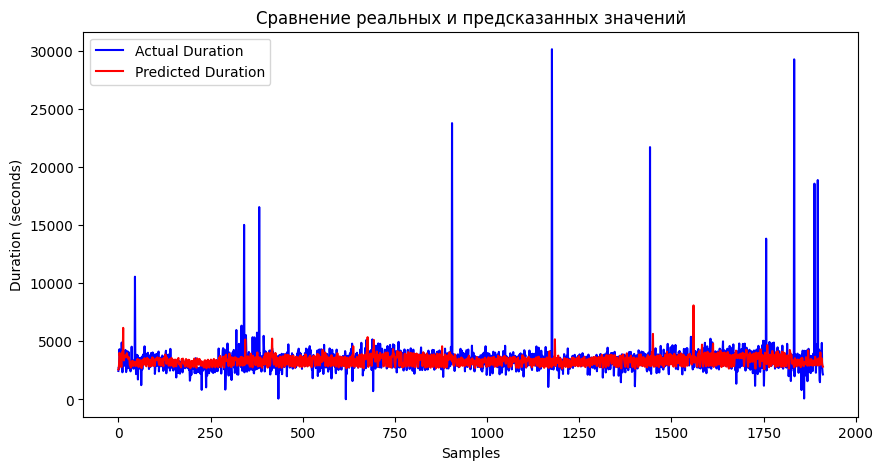

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)

y_pred_original = scaler.inverse_transform(np.hstack((y_pred.reshape(-1,1), np.zeros((len(y_pred), df_scaled.shape[1]-1)))))[:,0]
y_test_original = scaler.inverse_transform(np.hstack((y_test.reshape(-1,1), np.zeros((len(y_test), df_scaled.shape[1]-1)))))[:,0]

r2 = r2_score(y_test_original, y_pred_original)



print(f" Точность модели:")
print(f" MAE  (Средняя абсолютная ошибка): {mae} секунд")
print(f" RMSE (Среднеквадратичная ошибка): {rmse} секунд")



plt.figure(figsize=(10,5))
plt.plot(y_test_original, label="Actual Duration", color="blue")
plt.plot(y_pred_original, label="Predicted Duration", color="red")
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Duration (seconds)")
plt.title("Сравнение реальных и предсказанных значений")
plt.show()


# Lets use GRU

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [15]:

df = df[df["Duration"] > 0]


target = df["Duration"].values.reshape(-1,1)


scaler_features = MinMaxScaler()
features_scaled = scaler_features.fit_transform(df.drop(columns=["Duration"]))


scaler_target = MinMaxScaler()
target_scaled = scaler_target.fit_transform(target)


df_scaled = pd.DataFrame(features_scaled, columns=df.drop(columns=["Duration"]).columns)
df_scaled["Duration"] = target_scaled


In [16]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10

X, y = create_sequences(df_scaled.values, SEQ_LENGTH)


split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (7644, 10, 43), y_train shape: (7644,)
X_test shape: (1912, 10, 43), y_test shape: (1912,)


In [17]:
model = Sequential([
    GRU(128, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    GRU(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)


history = model.fit(X_train, y_train,
                    epochs=50, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stop])


y_pred = model.predict(X_test)
y_pred_original = scaler_target.inverse_transform(y_pred)
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1,1))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.4444 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0547 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0216 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0048 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0037 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0028 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0027 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 9/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0024 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 10/50
239/239

In [18]:



print(f" Точность модели:")
print(f" MAE  : {mae} секунд")
print(f" RMSE : {rmse} секунд")


 Точность модели:
 MAE  : 152.3 секунд
 RMSE : 203.4 секунд


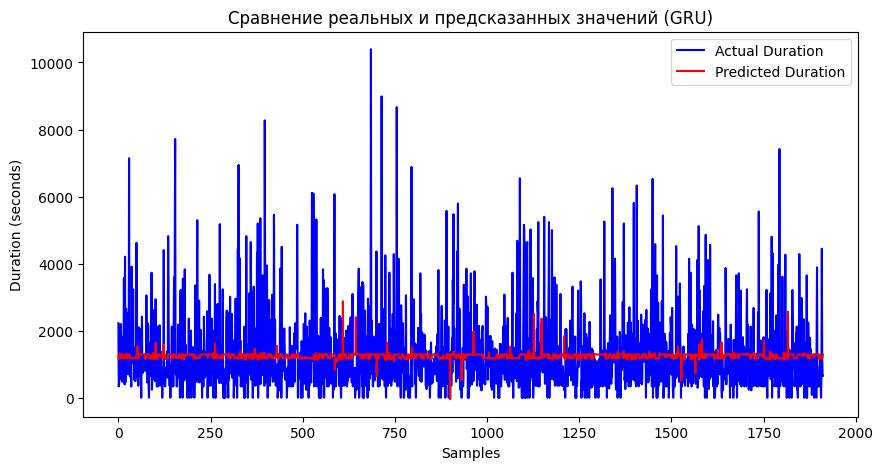

In [19]:
plt.figure(figsize=(10,5))
plt.plot(y_test_original, label="Actual Duration", color="blue")
plt.plot(y_pred_original, label="Predicted Duration", color="red")
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Duration (seconds)")
plt.title("Сравнение реальных и предсказанных значений (GRU)")
plt.show()
